In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json

import torch
from torch.utils.data import DataLoader

In [2]:
from importlib import reload

In [3]:
from tevatron.modeling.dense import DensePooler

In [4]:
from train import load_data
from torchfm.dataset.pecos_fm_format import PecosFMDataset, pair_collate_fn
from torchfm.model.efm import EmbeddingFactorizationMachineModel

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_dset(emb_dir, lbl_dir, lbl_suffix):
    X_trn, X_tst, Y_trn, Y_tst, Z = load_data(emb_dir, lbl_dir, lbl_suffix, None)
    dset_trn = PecosFMDataset(X_trn['embs'], Z['embs'], Y_trn, n_train_zs=8)
    return dset_trn

In [8]:
emb_dir = '../tevatron/examples/coCondenser-marco/retriever_model_s1_v0/embs/'
lbl_dir = '../data/MS-MARCO/Ys/'
lbl_suffix = '400k'

dset_trn = get_dset(emb_dir, lbl_dir, lbl_suffix)

X_trn.shape = (502939, 768), X_tst.shape = (6980, 768), Z.shape = (8841823, 768)
Y_trn.pos.nnz = 426214, Y_trn.neg.nnz = 381231974, Y_tst.pos.nnz = 7436, Y_tst.neg.nnz = 0


In [9]:
dl_trn = DataLoader(dset_trn, batch_size=8, shuffle=False,
                    num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

In [15]:
fm_model_dir = 'models/fm_k768_400k_ip/'
model = EmbeddingFactorizationMachineModel.load(fm_model_dir)
model.eval().to(device)

In [31]:
n_total = 0
z_total = 0
ez_total = 0

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        # xs = xs.to(device)
        zs = zs.to(device)
        # exs = model.encode_x(xs)
        ezs = model.encode_z(zs)
        
        # xs_norm = torch.norm(xs, dim=1)
        # exs_norm = torch.norm(exs, dim=1)
        # x_norm_comp = exs_norm > xs_norm
        # x_total += x_norm_comp.sum().item()
        
        pos_z_iis = torch.arange(xs.shape[0], device=xs.device, dtype=torch.long) * 8
        pos_z_mask = torch.zeros(zs.shape[0], device=zs.device, dtype=torch.long)
        pos_z_mask[pos_z_iis] = 1
        pos_z_mask = pos_z_mask.bool()
        
        pos_zs_norm = torch.norm(zs[pos_z_mask], dim=1)
        neg_zs_norm = torch.norm(zs[~pos_z_mask], dim=1).view(xs.shape[0], 7)
        
        pos_ezs_norm = torch.norm(ezs[pos_z_mask], dim=1)
        neg_ezs_norm = torch.norm(ezs[~pos_z_mask], dim=1).view(xs.shape[0], 7)
        
        z_norm_comp = pos_zs_norm > neg_zs_norm.mean(1)
        z_total += z_norm_comp.sum().item()
        ez_norm_comp = pos_ezs_norm > neg_ezs_norm.mean(1)
        ez_total += ez_norm_comp.sum().item()
        
        n_total += xs.shape[0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f376dd6e700>
Traceback (most recent call last):
  File "/local/workspace_1/miniconda3/envs/tevatron/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/local/workspace_1/miniconda3/envs/tevatron/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/local/workspace_1/miniconda3/envs/tevatron/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f376dd6e700>
Traceback (most recent call last):
  File "/local/workspace_1/miniconda3/envs/tevatron/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/local/wo

  0%|          | 0/50098 [00:06<?, ?it/s]

In [32]:
print(z_total / n_total, ez_total / n_total)

0.6202514590262512 0.6138888819579771


### Conclusion
1. positive passages does not have longer norm after linear projection
2. in general, positive passages have longer norm than negative passages

In [48]:
def plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev=None, 
               control_name='s1v0', exp_name='IP'):
    
    nfig = 2
    if ev is not None:
        nfig += 1
    
    fig, axs = plt.subplots(1, nfig, figsize=(5 * nfig, 4.5))

    ax = axs[0]
    bins = np.linspace((min(pos_scores.min(), epos_scores.min()) // 10) * 10, 
                       (1 + max(pos_scores.max(), epos_scores.max()) // 10) * 10, 40)
    ax.hist(pos_scores, bins=bins, alpha=0.5, label=control_name)
    ax.hist(epos_scores, bins=bins, alpha=0.5, label=exp_name)
    ax.set_title('Positive Embeddings')
    ax.legend(loc='upper right')

    ax = axs[1]
    bins = np.linspace((min(neg_scores.min(), eneg_scores.min()) // 10) * 10, 
                       (1 + max(neg_scores.max(), eneg_scores.max()) // 10) * 10, 40)
    ax.hist(np.reshape(neg_scores, -1), bins=bins, alpha=0.5, label=control_name)
    ax.hist(np.reshape(eneg_scores, -1), bins=bins, alpha=0.5, label=exp_name)
    ax.set_title('Negative Embeddings')
    ax.legend(loc='upper right')

    if ev is not None:
        ax = axs[2]
        ax.hist(ev, alpha=0.5, label='Eigenvalues', bins=20)
        ax.set_title('Px*Pz.T Eigenvalues')

    fig.tight_layout()
    
def plot_diff_hists(name_scores_dict):
    nfig = 1
    fig, ax = plt.subplots(1, nfig, figsize=(5 * nfig, 4.5))
    nbins = 80
    bin_min = np.min([scores_diff.min() for name, scores_diff in name_scores_dict.items()])
    bin_max = np.max([scores_diff.max() for name, scores_diff in name_scores_dict.items()])
    bins = np.linspace((bin_min // 10) * 10, (1 + bin_max // 10) * 10, nbins)
    
    for name, scores_diff in name_scores_dict.items():
        ax.hist(scores_diff, bins=bins, alpha=0.5, label=name)
    ax.set_title('Score Diff (pos - neg)')
    ax.legend(loc='upper right')
    
    fig.tight_layout()

In [21]:
dl_trn = DataLoader(dset_trn, batch_size=1, shuffle=False,
                    num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

In [12]:
pos_scores, neg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        preds = torch.matmul(xs, zs.T)
        
        pos_scores.append(preds[:, 0].cpu().numpy())
        neg_scores.append(preds[:, 1:].cpu().numpy())
        
pos_scores = np.concatenate(pos_scores, axis=0)
neg_scores = np.concatenate(neg_scores, axis=0)

print(pos_scores.mean(), neg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

187.232 166.84737


In [13]:
%ls models

bce/                      fm_ip_symmetric_if1/
ce_init_identity/         fm_ip_symmetric_nepochs40/
ce_init_random/           fm_k1536_400k_ip/
fm_ip_16-4/               fm_k192_400k_ip/
fm_ip_16-8/               fm_k384_400k_ip/
fm_ip_32-2/               fm_k768_400k_bias/
fm_ip_asymmetric_normed/  fm_k768_400k_fm/
fm_ip_asymmetric_wd0/     fm_k768_400k_fm_bias/
fm_ip_nepochs50/          fm_k768_400k_ip/
fm_ip_psd/                fm_k768_400k_ip_nepochs20/
fm_ip_symmetric/          fm_k768_400k_ip_tanh/
fm_ip_symmetric_if0/      stage1/
fm_ip_symmetric_if0.1/    stage2_original/


In [49]:
name_scores_dict = {}

In [60]:
name_scores_dict['baseline'] = pos_scores - neg_scores.mean(1)

### Frozen asymmetric

In [50]:
fm_model_dir = 'models/fm_k768_400k_ip/'
model = EmbeddingFactorizationMachineModel.load(fm_model_dir)
model.eval().to(device)

EmbeddingFactorizationMachineModel(
  (x_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
  (z_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
)

In [51]:
ev, _ = np.linalg.eig(model.z_dim_reduc.weight.detach().cpu().numpy().T @\
                      model.x_dim_reduc.weight.detach().cpu().numpy())

epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = model(xs, zs)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

126.989296 113.273705


/home/cybai/.conda/envs/tevatron/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/cybai/.conda/envs/tevatron/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


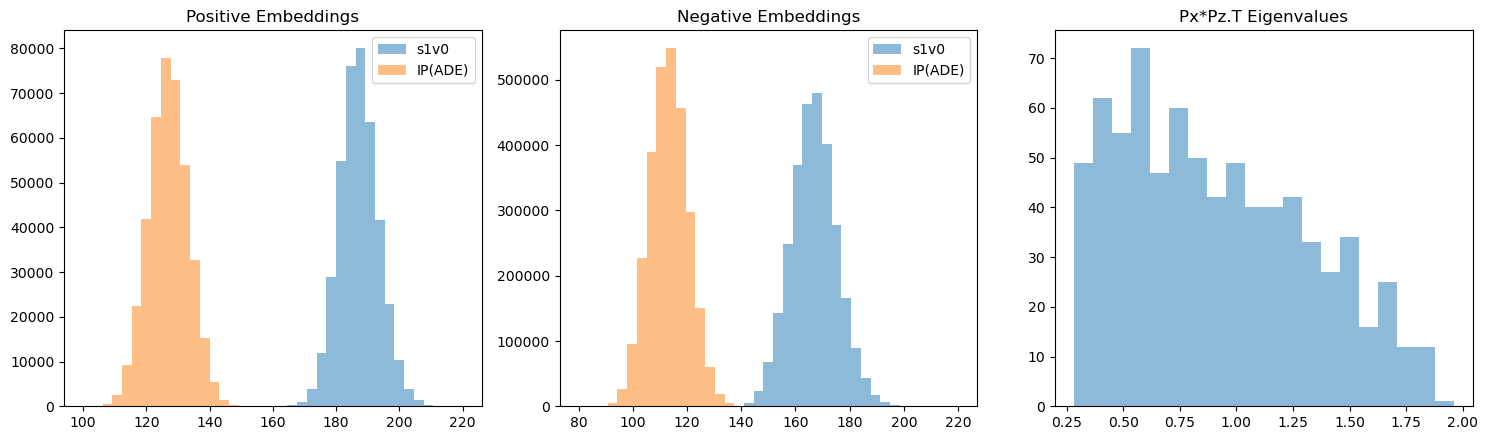

In [25]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, control_name='s1v0', exp_name='IP(ADE)')

In [52]:
name_scores_dict['asymmetric'] = epos_scores - eneg_scores.mean(1)

### Frozen symmetric

In [53]:
fm_model_dir = 'models/fm_ip_symmetric/'
model = EmbeddingFactorizationMachineModel.load(fm_model_dir)
model.eval().to(device)

EmbeddingFactorizationMachineModel(
  (x_dim_reduc): SymmetricLinear()
  (z_dim_reduc): Identity()
)

In [54]:
QSQT = model.x_dim_reduc.Q @ torch.diag(model.x_dim_reduc.diag) @ model.x_dim_reduc.Q.T
ev, _ = np.linalg.eig(QSQT.detach().cpu().numpy())

epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = model(xs, zs)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

128.96204 115.70362


(array([ 15.,  51., 110., 161., 153., 154.,  82.,  35.,   6.,   1.]),
 array([0.8540226 , 0.86841196, 0.88280123, 0.8971906 , 0.9115799 ,
        0.92596924, 0.9403585 , 0.95474786, 0.9691372 , 0.98352647,
        0.9979158 ], dtype=float32),
 <BarContainer object of 10 artists>)

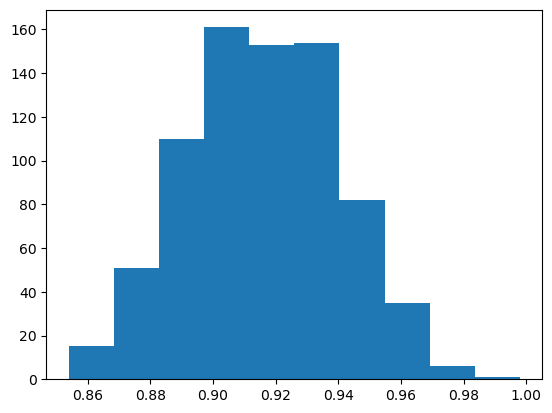

In [17]:
plt.hist(model.x_dim_reduc.diag.detach().cpu().numpy())

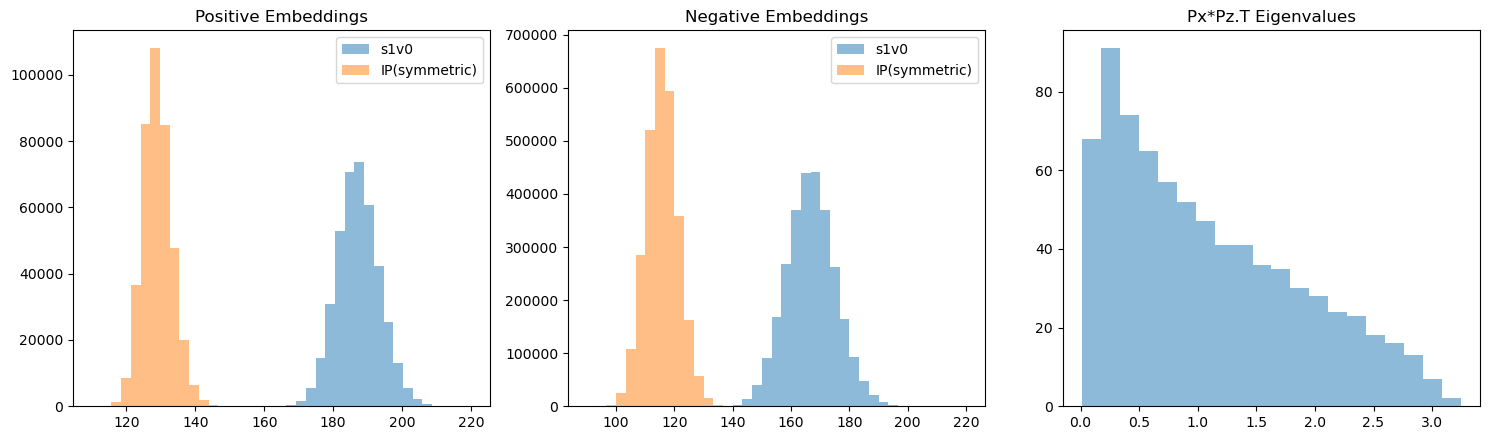

In [21]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, exp_name='IP(symmetric)')

In [55]:
name_scores_dict['symmetric'] = epos_scores - eneg_scores.mean(1)

### Frozen PSD

In [56]:
fm_model_dir = 'models/fm_ip_psd/'
model = EmbeddingFactorizationMachineModel.load(fm_model_dir)
model.eval().to(device)

EmbeddingFactorizationMachineModel(
  (x_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
  (z_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
)

In [57]:
ev, _ = np.linalg.eig(model.z_dim_reduc.weight.detach().cpu().numpy().T @\
                      model.x_dim_reduc.weight.detach().cpu().numpy())

In [58]:
epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = model(xs, zs)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

137.30893 123.82292


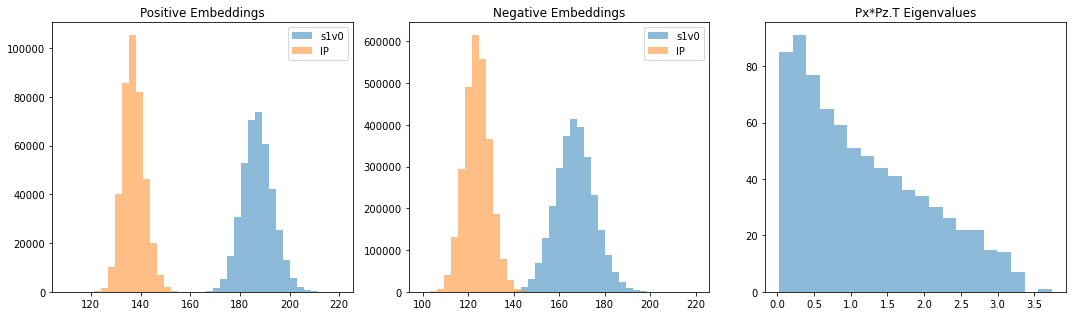

In [155]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev)

In [59]:
name_scores_dict['PSD'] = epos_scores - eneg_scores.mean(1)

### Plot score diff histograms

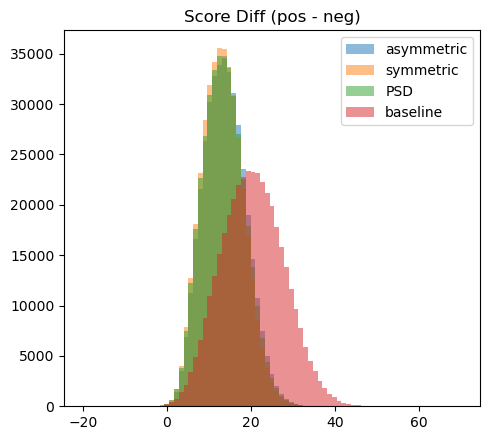

In [61]:
plot_diff_hists(name_scores_dict)

### Frozen symmetric over training

In [28]:
%ls 'models/fm_ip_symmetric/checkpoints'

fm_step=1000000.pth  fm_step=1500000.pth  fm_step=500000.pth
fm_step=1250000.pth  fm_step=250000.pth   fm_step=750000.pth


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/400781 [00:00<?, ?it/s]

179.60098 162.12492


  0%|          | 0/400781 [00:00<?, ?it/s]

143.32426 129.06319


  0%|          | 0/400781 [00:00<?, ?it/s]

134.15108 120.616394


  0%|          | 0/400781 [00:00<?, ?it/s]

130.33112 117.009445


  0%|          | 0/400781 [00:00<?, ?it/s]

129.43861 116.16024


  0%|          | 0/400781 [00:00<?, ?it/s]

129.05074 115.83602


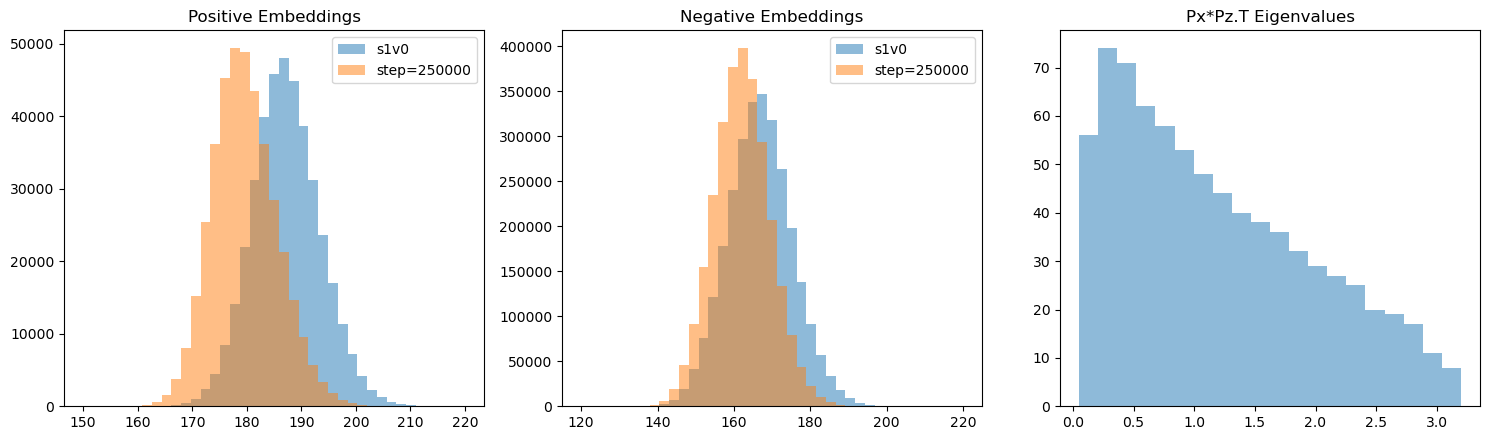

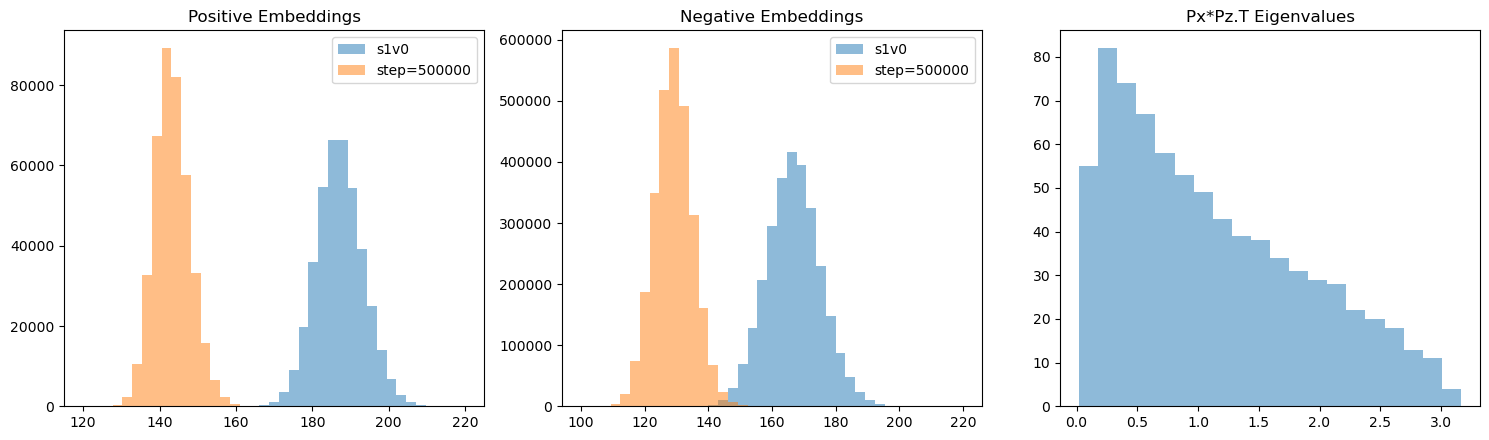

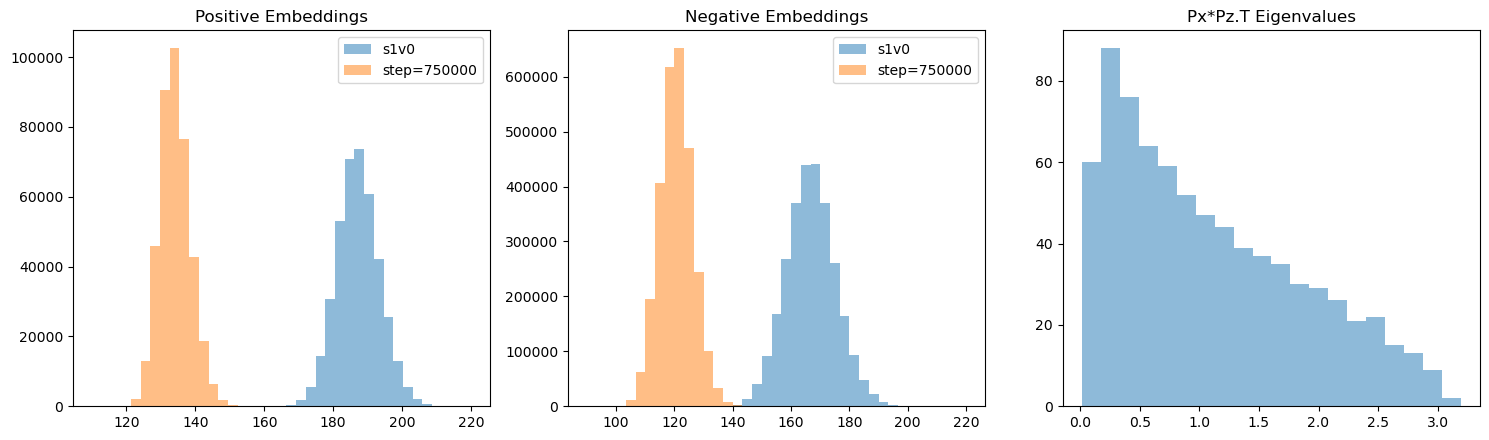

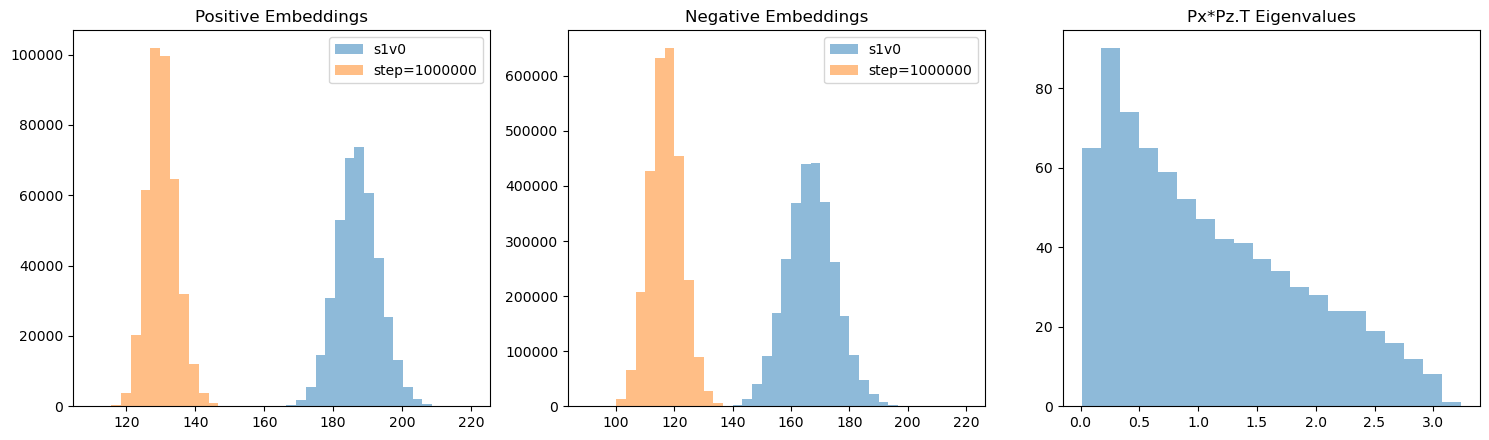

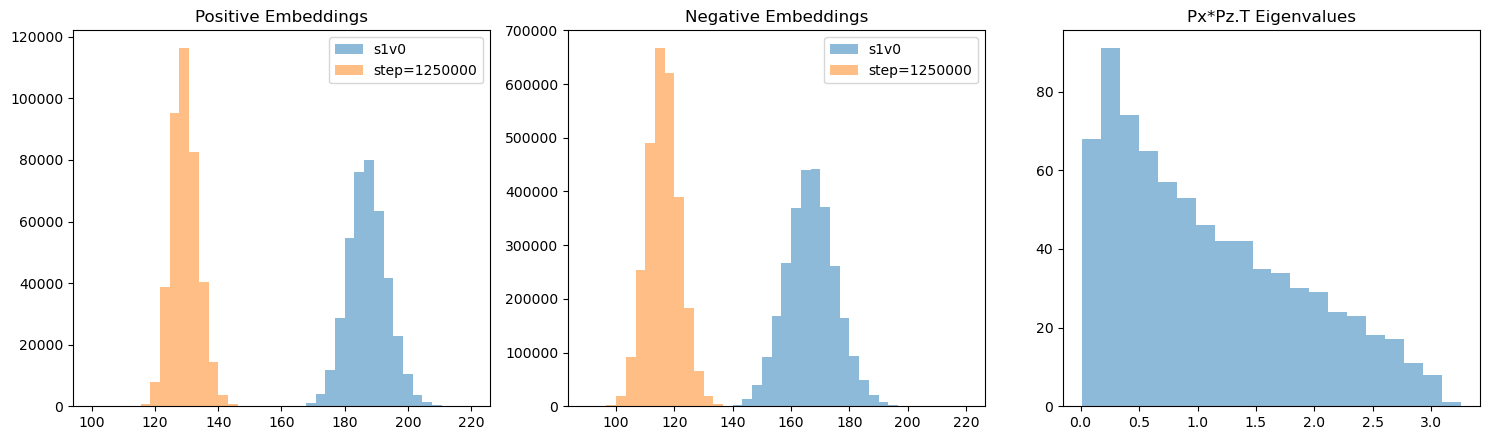

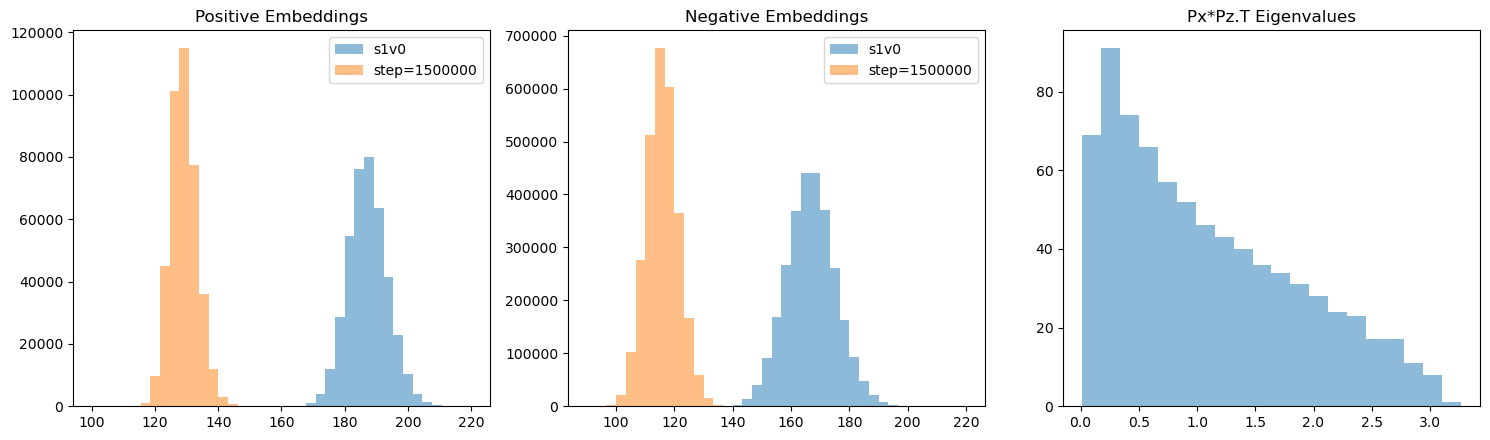

In [16]:
for step in tqdm([250000, 500000, 750000, 1000000, 1250000, 1500000], leave=False):
    fm_model_dir = 'models/fm_ip_symmetric/'
    fm_model_ckpt = f'models/fm_ip_symmetric/checkpoints/fm_step={step}.pth'
    model = EmbeddingFactorizationMachineModel.load(fm_model_dir, fm_model_ckpt)
    model.eval().to(device)
    
    QSQT = model.x_dim_reduc.Q @ torch.diag(model.x_dim_reduc.diag) @ model.x_dim_reduc.Q.T
    ev, _ = np.linalg.eig(QSQT.detach().cpu().numpy())

    epos_scores, eneg_scores = [], []

    with torch.no_grad():
        for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
            xs = xs.to(device)
            zs = zs.to(device)

            epreds = model(xs, zs)

            epos_scores.append(epreds[:, 0].cpu().numpy())
            eneg_scores.append(epreds[:, 1:].cpu().numpy())

    epos_scores = np.concatenate(epos_scores, axis=0)
    eneg_scores = np.concatenate(eneg_scores, axis=0)

    print(epos_scores.mean(), eneg_scores.mean())
    
    plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, exp_name=f'step={step}')

### Frozen asymmetric (wd=0)

In [26]:
fm_model_dir = 'models/fm_ip_asymmetric_wd0/'
model = EmbeddingFactorizationMachineModel.load(fm_model_dir)
model.eval().to(device)

EmbeddingFactorizationMachineModel(
  (x_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
  (z_dim_reduc): Linear(in_features=768, out_features=768, bias=False)
)

In [27]:
ev, _ = np.linalg.eig(model.z_dim_reduc.weight.detach().cpu().numpy().T @\
                      model.x_dim_reduc.weight.detach().cpu().numpy())

epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_trn, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = model(xs, zs)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

178.04282 159.84058


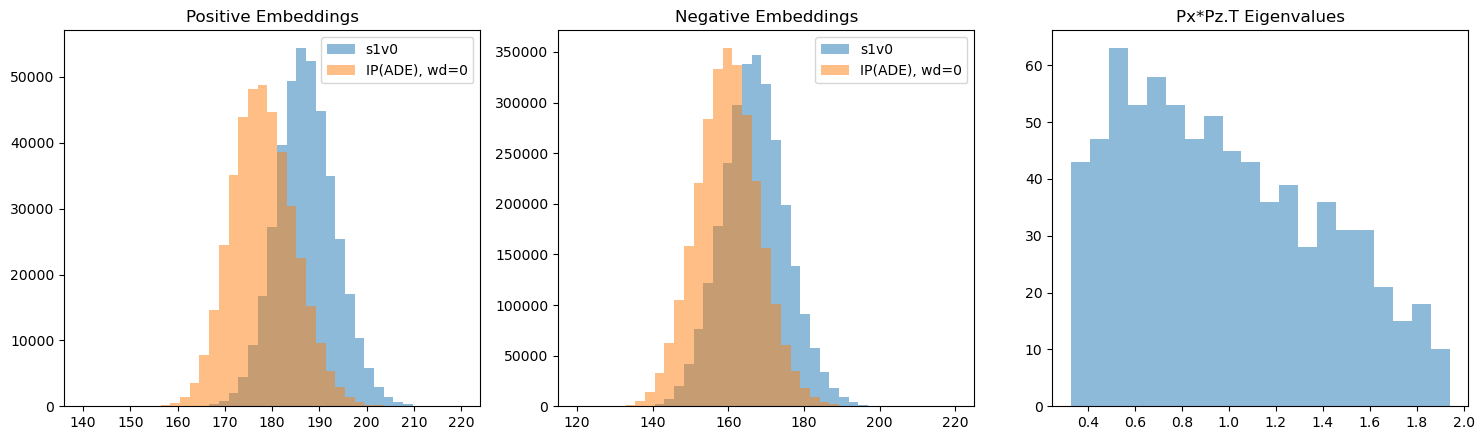

In [28]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, 
           control_name='s1v0', exp_name='IP(ADE), wd=0')

### End-to-end untie

In [158]:
emb_dir = '../tevatron/examples/coCondenser-marco/retriever_model_s1_untie/embs'
lbl_dir = '../data/MS-MARCO/Ys/'
lbl_suffix = '400k'

dset_untie = get_dset(emb_dir, lbl_dir, lbl_suffix)
dl_untie = DataLoader(dset_untie, batch_size=1, shuffle=False,
                      num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

X_trn.shape = (502939, 768), X_tst.shape = (6980, 768), Z.shape = (8841823, 768)
Y_trn.pos.nnz = 426214, Y_trn.neg.nnz = 381231974, Y_tst.pos.nnz = 7436, Y_tst.neg.nnz = 0


In [160]:
epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_untie, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = torch.matmul(xs, zs.T)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:01<?, ?it/s]

179.53029 157.39114


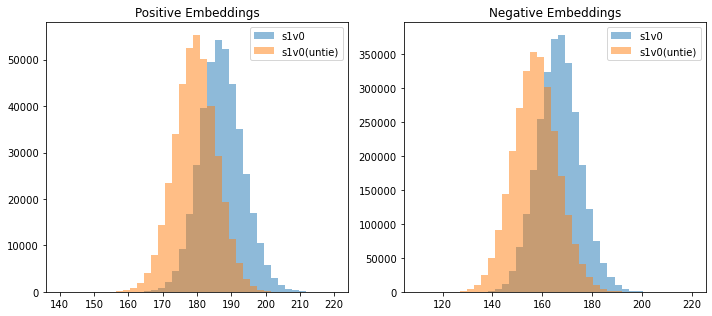

In [177]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, control_name='s1v0', exp_name='s1v0(untie)')

In [174]:
del dset_untie, dl_untie

### End-to-end asymmetric

In [22]:
emb_dir = '../tevatron/examples/coCondenser-marco/retriever_model_s1_ade/embs'
lbl_dir = '../data/MS-MARCO/Ys/'
lbl_suffix = '400k'

dset_ade = get_dset(emb_dir, lbl_dir, lbl_suffix)
dl_ade = DataLoader(dset_ade, batch_size=1, shuffle=False,
                    num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

X_trn.shape = (502939, 768), X_tst.shape = (6980, 768), Z.shape = (8841823, 768)
Y_trn.pos.nnz = 426214, Y_trn.neg.nnz = 381231974, Y_tst.pos.nnz = 7436, Y_tst.neg.nnz = 0


In [23]:
epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_ade, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = torch.matmul(xs, zs.T)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:01<?, ?it/s]

198.53458 178.261


In [24]:
weights = torch.load('../tevatron/examples/coCondenser-marco/retriever_model_s1_ade/pooler.pt')
ev, _ = np.linalg.eig(weights['linear_p.weight'].detach().cpu().numpy().T @\
                      weights['linear_q.weight'].detach().cpu().numpy())

/home/cybai/.conda/envs/tevatron/lib/python3.9/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/cybai/.conda/envs/tevatron/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


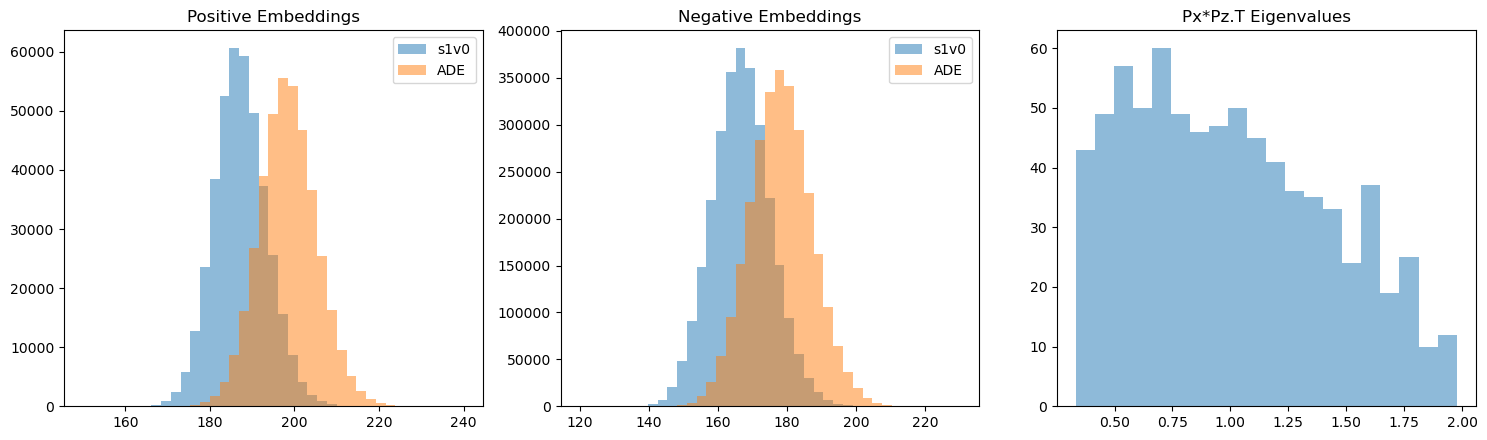

In [25]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, control_name='s1v0', exp_name='ADE')

In [206]:
del dset_ade, dl_ade, weights

### End-to-end PSD

In [207]:
model_dir = '../tevatron/examples/coCondenser-marco/retriever_model_s1_sde'
emb_dir = model_dir + '/embs'
lbl_dir = '../data/MS-MARCO/Ys/'
lbl_suffix = '400k'

dset_sde = get_dset(emb_dir, lbl_dir, lbl_suffix)
dl_sde = DataLoader(dset_sde, batch_size=1, shuffle=False,
                    num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

X_trn.shape = (502939, 768), X_tst.shape = (6980, 768), Z.shape = (8841823, 768)
Y_trn.pos.nnz = 426214, Y_trn.neg.nnz = 381231974, Y_tst.pos.nnz = 7436, Y_tst.neg.nnz = 0


In [208]:
epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_sde, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = torch.matmul(xs, zs.T)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:01<?, ?it/s]

223.91852 203.29128


In [212]:
weights = torch.load(model_dir + '/pooler.pt')
ev, _ = np.linalg.eig(weights['linear_p.weight'].detach().cpu().numpy().T @\
                      weights['linear_q.weight'].detach().cpu().numpy())

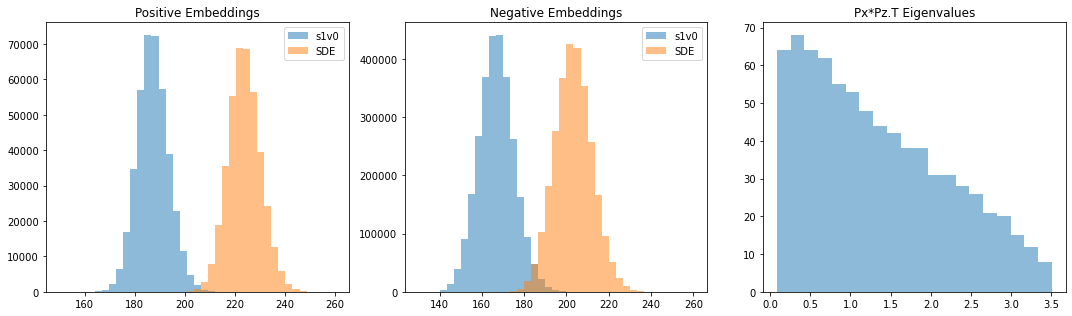

In [213]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, control_name='s1v0', exp_name='SDE')

In [214]:
del dset_sde, dl_sde, weights

### End-to-end symmetric

In [17]:
model_dir = '../tevatron/examples/coCondenser-marco/retriever_model_s1_ssde'
emb_dir = model_dir + '/embs'
lbl_dir = '../data/MS-MARCO/Ys/'
lbl_suffix = '400k'

dset_ssde = get_dset(emb_dir, lbl_dir, lbl_suffix)
dl_ssde = DataLoader(dset_ssde, batch_size=1, shuffle=False,
                     num_workers=8, drop_last=False, collate_fn=pair_collate_fn)

X_trn.shape = (502939, 768), X_tst.shape = (6980, 768), Z.shape = (8841823, 768)
Y_trn.pos.nnz = 426214, Y_trn.neg.nnz = 381231974, Y_tst.pos.nnz = 7436, Y_tst.neg.nnz = 0


In [18]:
epos_scores, eneg_scores = [], []

with torch.no_grad():
    for i, (xs, zs) in enumerate(tqdm(dl_ssde, leave=False)):
        xs = xs.to(device)
        zs = zs.to(device)
        
        epreds = torch.matmul(xs, zs.T)
        
        epos_scores.append(epreds[:, 0].cpu().numpy())
        eneg_scores.append(epreds[:, 1:].cpu().numpy())

epos_scores = np.concatenate(epos_scores, axis=0)
eneg_scores = np.concatenate(eneg_scores, axis=0)

print(epos_scores.mean(), eneg_scores.mean())

  0%|          | 0/400781 [00:00<?, ?it/s]

220.55081 199.8962


In [19]:
weights = torch.load(model_dir + '/pooler.pt')
QSQT = weights['linear_q.Q'] @ torch.diag(weights['linear_q.diag']) @ weights['linear_q.Q'].T
ev, _ = np.linalg.eig(QSQT.detach().cpu().numpy())

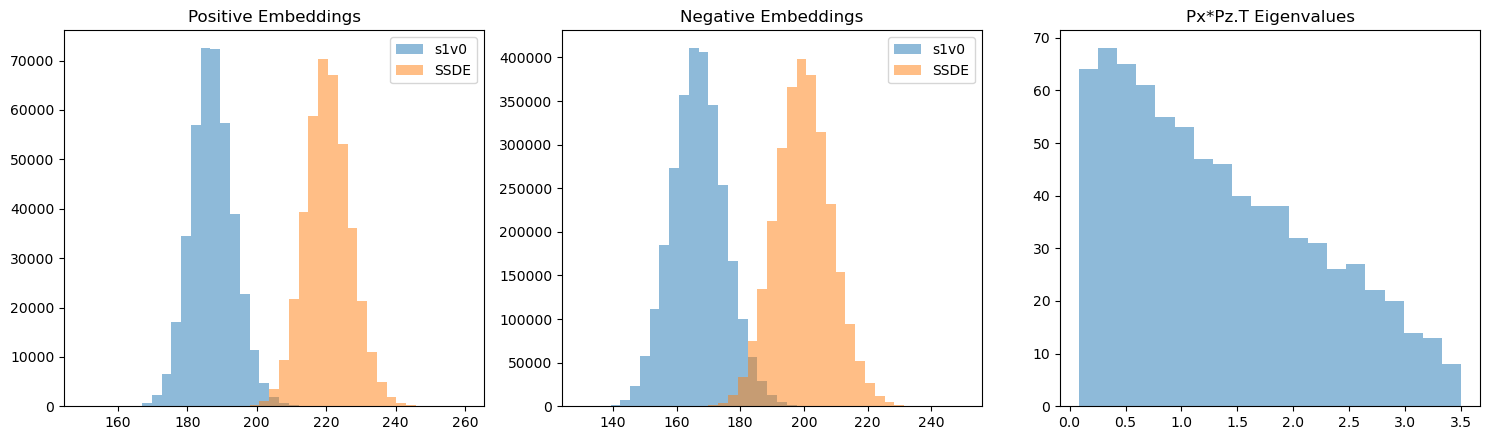

In [20]:
plot_hists(pos_scores, neg_scores, epos_scores, eneg_scores, ev, control_name='s1v0', exp_name='SSDE')

In [22]:
del dset_ssde, dl_ssde, weights